<a href="https://colab.research.google.com/github/ballmdr/Forex-Prediction-Machine_Learning/blob/master/Forex_Pytorch_ResNet_%2B_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fxcmpy

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import fxcmpy
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import skimage as sk
from skimage.transform import resize
import pywt
import pickle
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from google.colab import drive
drive.mount('/content/drive')

def connect():
    return fxcmpy.fxcmpy(access_token=access_token, server=server)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
con = connect()

W0805 05:47:56.095273 139779844626304 fxcmpy.py:222] Default account set to 96112465, to change use set_default_account().


In [0]:
access_token = '757cf3bec951c194aaa61c9db954c6533d251f2f'
server = 'real'
symbol = 'EURUSD'
symbol2 = 'EUR/USD'
timeframe = 'H1'
windows = 6
target_windows = 3
digits = 10000
ratio = 10
n_prices = 10000
K = 3

In [0]:
def dfProcess(df):
# Short-Term
# ใช้ค่า 3, 5, 8, 10, 12, or 15.
# Long-Term
# ใช้ค่า 30, 35, 40, 45, 50, or 60.
  df['ma3'] = np.round(df.close.rolling(3).mean(), 5)
  df['ma5'] = np.round(df.close.rolling(5).mean(), 5)
  df['ma8'] = np.round(df.close.rolling(8).mean(), 5)
  df['ma10'] = np.round(df.close.rolling(10).mean(), 5)
  df['ma12'] = np.round(df.close.rolling(12).mean(), 5)
  df['ma15'] = np.round(df.close.rolling(15).mean(), 5)
  #df['ma20'] = np.round(df.close.rolling(20).mean(), 5)
  #df['ma7_shift3'] = df.ma7.shift(-3)
  #df['ma10_shift3'] = df.ma10.shift(-3)
  #df['close_shift3'] = df.close.shift(-3)
  df['close_diff_pip'] = - df.close.diff(-target_windows) * digits
  
  arr = ['0', '1', '2' ]
  for i in range(1, target_windows):
    df[arr[i]] = - df.close.diff(-i) * digits
    
  df.dropna(inplace=True)

  #df['close_target_percent'] = np.round((df['close_diff_pip']*digits)/df.close, 2) * 100
  #df['7_10_target_percent'] = np.round(((df['ma7_shift3']-df['ma10_shift3'])*digits)/df['ma10_shift3'], 2)
  #df['5_7_target_percent'] = np.round(((df.ma5-df.ma7)*digits)/df.ma7, 2)
  

  df['Target'] = np.ones(len(df))
  # df['Target'].loc[(df['close_target_percent'] > 9) & (df['7_10_target_percent'] > 1) & (df['5_7_target_percent'] > 1)] = 2
  # df['Target'].loc[(df['close_target_percent'] < -9) & (df['7_10_target_percent'] < -1) & (df['5_7_target_percent'] < -1)] = 0
  df['Target'].loc[(df['close_diff_pip'] > ratio) &
                   (df['1'] > -ratio) &
                   (df['2'] > -ratio) 
                  ] = 2
  df['Target'].loc[(df['close_diff_pip'] < -ratio) &
                   (df['1'] < ratio) &
                   (df['2'] < ratio)                
                  ] = 0
  print(df.Target.value_counts())
  
  # df['returns'] = df.close.pct_change(1)
  # df['returns_5'] = df.close.pct_change(5)
  # df['log_return'] = np.log(df.returns)
  # df['log_return_5'] = np.log(df.returns_5)
  
  #df.drop(['bidopen', 'bidclose', 'bidhigh', 'askopen', 'askclose', 'askhigh', 'bidlow', 'asklow', 'tickqty', 'close_diff_pip', '1', '2', '3', '4'], axis=1, inplace=True)
  df.dropna(inplace=True)
  print(df.head())
  print(df.shape)
  
  print(df.info())
  
  return df


def getXY(df, windows):

  X = []
  Y = []
  for i in range(len(df)-(windows+1)):
    plt.style.use('dark_background')
    fig = plt.figure(frameon=False) 
    fig.set_size_inches(3,2)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    _df = df.iloc[i:windows]
    plt.plot(_df.ma3, color='red')
    plt.plot(_df.ma5, color='blue')
    plt.plot(_df.ma8, color='green')
    plt.plot(_df.ma10, color='orange')
    plt.plot(_df.ma12, color='black')
    plt.plot(_df.ma15, color='purple')
    #plt.plot(_df.open, color='black')
   # plt.plot(_df.close, color='purple')

    plt.savefig('tmp2.png')

    plt.close()

    img = plt.imread('tmp2.png')
    new_img = resize(img, (100,150))
    #print(new_img.shape)
    if i % 1000 == 0:
      print(i)
      plt.imshow(new_img)
      plt.show()
      print(i, ' - ', windows)
      print('target: ', df.Target.iloc[windows-1])
    X.append(new_img)
    Y.append(df.Target.iloc[windows-1])

    windows += 1

  return X, Y


In [0]:
def calScore(y_true, y_pred, e):
  #unique, counts = np.unique(np.argmax(y_pred, axis=1), return_counts=True)
  #print(np.asarray((unique, counts)).T)

  if type(y_true) == list or type(y_pred) == list:
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

  y_0 = np.where(y_true == 0.0)
  y_1 = np.where(y_true == 1.0)
  y_2 = np.where(y_true == 2.0)
  # y_3 = np.where(y_test == 3.0)
  # y_4 = np.where(y_test == 4.0)

  pred_0 = []
  pred_1 = []
  pred_2 = []

  for i in y_0[0]:
    pred_0.append(y_pred[i])
  for i in y_1[0]:
    pred_1.append(y_pred[i])
  for i in y_2[0]:
    pred_2.append(y_pred[i])
  # for i in y_3[0]:
  #   x_3.append(x_test[i])
  # for i in y_4[0]:
  #   x_4.append(x_test[i])

  pred_0 = np.array(pred_0)
  pred_1 = np.array(pred_1)
  pred_2 = np.array(pred_2)

  #acc1
  trade_acc0 = len(pred_0[pred_0==0]) + len(pred_0[pred_0==2])
  acc0_win = len(pred_0[pred_0==0])
  acc0_loss = len(pred_0[pred_0==2])

  #acc2
  trade_acc2 = len(pred_2[pred_2==0]) + len(pred_2[pred_2==2])
  acc2_win = len(pred_2[pred_2==2])
  acc2_loss = len(pred_2[pred_2==0])

  #acc1
  trade_acc1 = len(pred_1[pred_1==0]) + len(pred_1[pred_1==2])
  acc1_loss = trade_acc1
  total_trade = trade_acc0 + trade_acc1 + trade_acc2
  
  win_rate = 0.0
  loss_rate = 0.0
  if total_trade > 0:
    win_rate = (acc0_win + acc2_win) / total_trade * 100
    loss_rate = (acc0_loss + acc1_loss + acc2_loss) / total_trade * 100

  rr = 0.0
  if loss_rate > 0:
    rr = win_rate / loss_rate

  if e % 10 == 0:
    print("Trade acc0: ", trade_acc0)
    print('acc0 win: ', acc0_win)
    print('acc0 loss: ', acc0_loss)
    print('------')
    print("Trade acc2: ", trade_acc2)
    print('acc2 win: ', acc2_win)
    print('acc2 loss: ', acc2_loss)
    print('------')
    print("Trade acc1: ", trade_acc1)
    print('acc1 loss: ', acc1_loss)
    print('------')
    print("total trade: ", total_trade)
    print('rr: ', rr)
    print('win rate: ', np.round(win_rate, 2))
    print('loss rate:', np.round(loss_rate, 2))
    print('pred_0 max: ', pred_0.max())
    print('pred_2 min: ', pred_2.min())

  return rr, pred_0, pred_2

In [6]:
df = con.get_candles(symbol2, period=timeframe, number=n_prices)
df['close'] = (df.bidclose + df.askclose) / 2
df = dfProcess(df)

#df['close'] = (df.close - df.close.mean()) / (df.close.max() - df.close.min())
#print(df['close'].head())
#df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]



# pca = PCA(n_components=.90)
# train_data = pca.fit_transform(train_data)
# test_data = pca.transform(test_data)

# scale = StandardScaler()
# minmax = MinMaxScaler()
# train_data = minmax.fit_transform(train_data)
# test_data = minmax.transform(test_data)


NameError: ignored

0


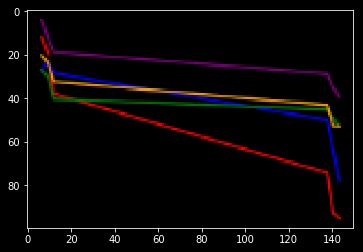

0  -  6
target:  2.0
1000


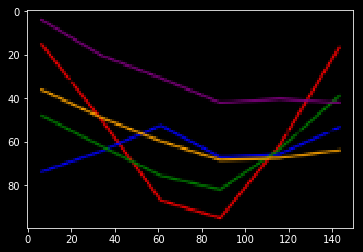

1000  -  1006
target:  1.0
2000


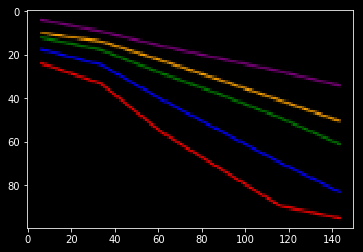

2000  -  2006
target:  0.0
3000


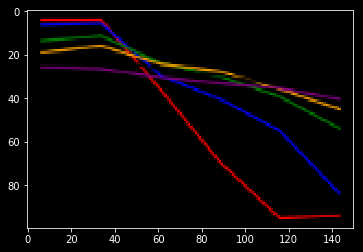

3000  -  3006
target:  0.0
4000


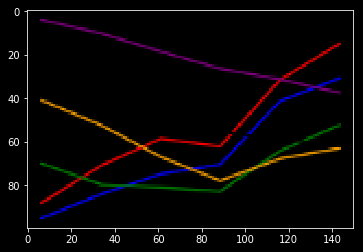

4000  -  4006
target:  1.0
5000


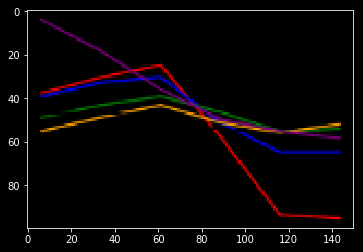

5000  -  5006
target:  1.0
0


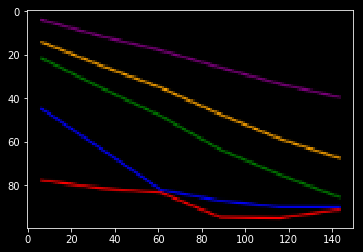

0  -  6
target:  1.0
1000


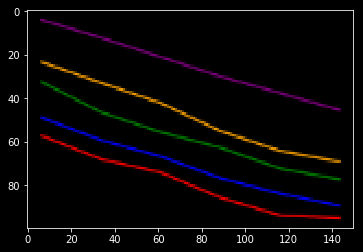

1000  -  1006
target:  1.0
2000


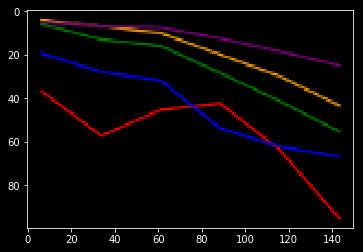

2000  -  2006
target:  1.0
3000


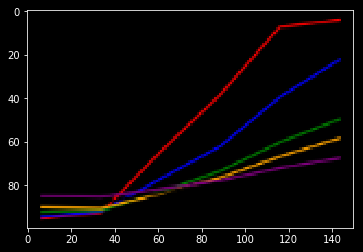

3000  -  3006
target:  2.0


In [0]:
split = int(len(df) * 0.60)
train_data = df.iloc[:split]
test_data = df.iloc[split:]

x_train, y_train = getXY(train_data, windows)
x_test, y_test = getXY(test_data, windows)

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/x_train_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'wb') as file:
  pickle.dump(x_train, file)
with open('/content/drive/My Drive/Colab Notebooks/y_train_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'wb') as file:
  pickle.dump(y_train, file)
with open('/content/drive/My Drive/Colab Notebooks/x_test_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'wb') as file:
  pickle.dump(x_test, file)
with open('/content/drive/My Drive/Colab Notebooks/y_test_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'wb') as file:
  pickle.dump(y_test, file)

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/x_train_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'rb') as file:
  x_train = pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/y_train_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'rb') as file:
  y_train = pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/x_test_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'rb') as file:
  x_test = pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/y_test_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'rb') as file:
  y_test = pickle.load(file)

In [0]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

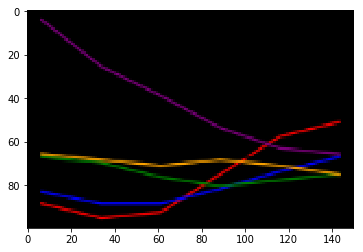

In [19]:
idx = np.random.randint(0, len(x_test)-1)
plt.imshow(x_test[idx])
plt.show()

In [0]:
x_test[0]

array([[[0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        ...,
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157]],

       [[0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        ...,
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157]],

       [[0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        ...,
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.      

In [0]:
x_train /= 255
x_test /= 255

In [0]:
def init_weights(m):
    # if isinstance(m, nn.Linear):
    #   size = m.weight.size()
    #   fan_out = size[0] # number of rows
    #   fan_in = size[1] # number of columns
    #   variance = np.sqrt(2.0/(fan_in))
    #   m.weight.data.normal_(0.0, variance)
    #   if m.bias is not None:
    #     m.bias.data.fill_(0)
    # elif isinstance(m, nn.Conv2d):
    #   size = m.weight.size()
    #   fan_out = size[0] # number of rows
    #   fan_in = size[1] # number of columns
    #   variance = np.sqrt(2.0/(fan_in))
    #   m.weight.data.normal_(0.0, variance)
    #   if m.bias is not None:
    #     m.bias.data.fill_(0)

    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

                   
#     if isinstance(m, nn.Conv2d):
#         n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#         m.weight.data.normal_(0, (2. / n)**.5)
#     elif isinstance(m, nn.BatchNorm2d):
#         m.weight.data.fill_(1)
#         m.bias.data.zero_()
        
        
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         import scipy.stats as stats
#         X = stats.truncnorm(-2, 2, scale=0.01)
#         values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
#         values = values.view(m.weight.size())
#         with torch.no_grad():
#             m.weight.copy_(values)
#     elif isinstance(m, nn.BatchNorm2d):
#         nn.init.constant_(m.weight, 1)
#         nn.init.constant_(m.bias, 0)

In [0]:

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, inplanes, planes, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.conv1 = conv3x3(inplanes, planes, stride)
    self.bn1 = nn.BatchNorm2d(planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = nn.BatchNorm2d(planes)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    residual = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
        residual = self.downsample(x)

    out += residual
    out = self.relu(out)

    return out
  
def resnet18(num_classes, hidden, n_layers):
    """Constructs a ResNet-18 model."""
    model = ResnetLSTM(BasicBlock, [2, 2, 2, 2], num_classes, hidden, n_layers)
    return model    
  
  
class ResnetLSTM(nn.Module):
  def __init__(self, block, layers, num_classes, hidden, n_layers):
    super(ResnetLSTM, self).__init__()
    self.inplanes = 16
    self.n_layers = n_layers

    self.conv1 = nn.Conv2d(4, 16, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(16)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, 32, layers[0])
    self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
    self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
    self.layer4 = self._make_layer(block, 256, layers[3], stride=2)
    self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
    self.fc = nn.Linear((256*2*3) * block.expansion, num_classes)
    
    #all_features = hidden*2 + width * height * channel
    all_features = 1544
    self.linearFt = nn.Linear(all_features, hidden)
    self.linearIt = nn.Linear(all_features, hidden)
    self.linearCt1 = nn.Linear(all_features, hidden)
    self.linearOt = nn.Linear(all_features, hidden)
    self.linearO = nn.Linear(50, num_classes)
    self.drop = nn.Dropout(p=0.50)
    self.softmax = nn.LogSoftmax(dim=1)

    self.linear1 = nn.Linear(all_features, 300)
    self.norm1 = nn.BatchNorm2d(300)
    self.linear2 = nn.Linear(300, 150)
    self.norm2 = nn.BatchNorm2d(150)
    self.linear3 = nn.Linear(150, 50)
    self.norm3 = nn.BatchNorm2d(50)


  def _make_layer(self, block, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes * block.expansion:
        downsample = nn.Sequential(
            nn.Conv2d(self.inplanes, planes * block.expansion,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(planes * block.expansion),
        )

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes * block.expansion
    for i in range(1, blocks):
        layers.append(block(self.inplanes, planes))

    return nn.Sequential(*layers)



  def forward(self, x, h, c):
    
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = F.dropout(x)

    x = self.layer1(x)
    x = F.dropout(x)
    x = self.layer2(x)
    x = F.dropout(x)
    x = self.layer3(x)
    x = F.dropout(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = F.dropout(x)
    #print(x.size())
    x = x.view(x.size(0), -1)
        
    #x = x.view(1, -1)
    for n in range(self.n_layers):
      combined = torch.cat((x, h), 1)
      #print('combined: ', combined.size())
      ft = torch.sigmoid(self.linearFt(combined))
      it = torch.sigmoid(self.linearIt(combined))
      ct1 = torch.tanh(self.linearCt1(combined))
      c = (ft*c) + (it * ct1)
      #c = (ft*c) + (1-ft) * ct1
      #c = self.drop(c)

      ot = torch.sigmoid(self.linearOt(combined))
      h = ot * torch.tanh(c)
      #h = self.drop(h)

    out = self.linear1(combined)
    out = torch.relu(out)
    out = self.linear2(out)
    out = torch.relu(out)
    out = self.linear3(out)
    out = torch.relu(out)
    out = self.softmax(self.linearO(out))
    
    return out, h, c




In [0]:
windows = 6
input_size = 1
hidden = 8
n_layers = 1
K = 3
epochs = 5000
train_loss = []
test_loss = []

#model = LSTM(hidden, K, input_size, n_layers, 50, 75, 512)
model = resnet18(K, hidden, n_layers)
model.apply(init_weights)
model.cuda()
loss_fn = nn.NLLLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.999, momentum=0.1)
lambda1 = lambda epoch: epochs // 30
#lambda2 = lambda epoch: 0.95 ** epochs
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 200, 400, 800, 1600, 3200, 6400], gamma=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#N = len(x_train)-(windows+1)

batch_size = 1
#N = int(len(x_train) - windows/batch_size)
N = len(x_train) - windows
#n_batch = int(N / batch_size)
n_batch = 32
best_acc = 0.0
best_rr = 0.0
print('n batch: ', n_batch)
for e in range(epochs):
    model.train()
    running_loss = 0.0
    testing_loss = 0.0
    for i in range(n_batch):
      optimizer.zero_grad()
      batch_loss = 0.0
      #y_train_true = torch.empty(batch_size, dtype=torch.long, device='cuda')
      #logits = torch.empty(batch_size, dtype=torch.float32, device='cuda')

      for j in range(batch_size):
        start = np.random.randint(1, len(x_train) - windows -10)
        end = start + windows
        #start = i*batch_size + j
        #end = i*batch_size + j + windows
        inputs = x_train[start:end]      
        
        y = y_train[end - 1]
        y_tensor = torch.tensor(np.array([y]), dtype=torch.long).cuda()
        h = torch.zeros([1, hidden], dtype=torch.float32).cuda()
        c = torch.zeros([1, hidden], dtype=torch.float32).cuda()

        for w in range(windows):
          if len(inputs[w].shape) < 3:
            print(inputs[w].shape)
            print(index, ' ', index+windows)
          x_tmp = inputs[w].reshape(1, 100, 150, 4)
          xt = np.transpose(x_tmp, (0, 3, 1, 2))
          x = torch.tensor(xt, dtype=torch.float32).cuda()
          out, h, c = model(x, h, c)
        
        #print('logits: ', out.cpu().detach().numpy()[0])
        # logits[j] = out.detach()
        # y_train_true[j] = y_tensor

        if j == 0:
          logits = out
          y_true = y_tensor
        else:
          logits = torch.cat((logits, out), 0)
          y_true = torch.cat((y_true, y_tensor))
        # print(j, ' ', y)
        # print(y_true)
        #loss += loss_fn(out, y_tensor.unsqueeze(0))

      # logits_tensor = torch.tensor(logits, dtype=torch.float32).cuda()
      # y_train_true_tensor = torch.tensor(y_train_true, dtype=torch.long).cuda()
      #print('end batch')
      loss = loss_fn(logits, y_true)

      #print('before backward: ', loss.item())
      #print(logits_tensor.size())
      #print(y_train_true_tensor.size())
     
      running_loss += loss.item() / n_batch
      loss.backward()
      optimizer.step()
        
    #print('end n_batch computing running loss')
    train_loss.append(running_loss)

    model.eval()
    y_true = list()
    y_pred = list()
    #test_count = len(x_test) - windows
    test_count = 100

    for j in range(test_count):
        index = np.random.randint(1, len(x_test) - windows -10)
        #index = j
        #print('index: ', index)
        h = torch.zeros([1, hidden], dtype=torch.float32).cuda()
        c = torch.zeros([1, hidden], dtype=torch.float32).cuda()
        
        inputs = x_test[index:index+windows]
        y = y_test[(index+windows)-1]
        y_tensor = torch.tensor(y, dtype=torch.long).cuda()

        if len(inputs) != windows:
          print('len invalid!')
          quit()
        for w in range(len(inputs)):
            if len(inputs[w].shape) < 3:
              print(inputs[w].shape)
              print(index, ' ', index+windows)
            xt = np.transpose(x_tmp, (0, 3, 1, 2))
            x = torch.tensor(xt, dtype=torch.float32).cuda()
            out, h, c = model(x, h, c)

        loss = loss_fn(out, y_tensor.unsqueeze(0))
        testing_loss += loss.item()

        y_pred.append(out.cpu().detach().numpy().argmax(1)[0])
        y_true.append(y)
    
    avg_loss = testing_loss / test_count
    test_loss.append(avg_loss)
    scheduler.step(avg_loss)
    
    rr, pred_0, pred_2 = calScore(y_true, y_pred, e)
    if e % 10 == 0:
      print(e, ' Train Loss: ', running_loss, ' Test Loss: ', avg_loss)
    if rr > best_rr and np.max(pred_0) ==1 and np.min(pred_2) == 1:
        best_rr = rr
        torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/torch_CNN_LSTM' + symbol + '_' + timeframe)
        print('saved!')

n batch:  32
Trade acc0:  0
acc0 win:  0
acc0 loss:  0
------
Trade acc2:  0
acc2 win:  0
acc2 loss:  0
------
Trade acc1:  0
acc1 loss:  0
------
total trade:  0
rr:  0.0
win rate:  0.0
loss rate: 0.0
pred_0 max:  1
pred_2 min:  1
0  Train Loss:  1.0899166651070118  Test Loss:  1.0696999502182007


In [23]:
windows = 6
input_size = 1
hidden = 8
n_layers = 1
K = 3
epochs = 5000
train_loss = []
test_loss = []

#model = LSTM(hidden, K, input_size, n_layers, 50, 75, 512)
model = resnet18(K)
model.apply(init_weights)
model.cuda()
loss_fn = nn.NLLLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.999, momentum=0.1)
lambda1 = lambda epoch: epochs // 30
#lambda2 = lambda epoch: 0.95 ** epochs
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1])
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 200, 400, 800, 1600, 3200, 6400], gamma=0.1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#N = len(x_train)-(windows+1)

batch_size = 32
#N = int(len(x_train) - windows/batch_size)
N = len(x_train) - windows
#n_batch = int(N / batch_size)
n_batch = 32
best_acc = 0.0
best_rr = 0.0
print('n batch: ', n_batch)
for e in range(epochs):
    model.train()
    running_loss = 0.0
    testing_loss = 0.0
    for i in range(n_batch):
      optimizer.zero_grad()
      batch_loss = 0.0
      #y_train_true = torch.empty(batch_size, dtype=torch.long, device='cuda')
      #logits = torch.empty(batch_size, dtype=torch.float32, device='cuda')

      for j in range(batch_size):
        start = np.random.randint(1, len(x_train) - windows -10)
        end = start + windows
        #start = i*batch_size + j
        #end = i*batch_size + j + windows
        inputs = x_train[start:end]      
        
        y = y_train[end - 1]
        y_tensor = torch.tensor(np.array([y]), dtype=torch.long).cuda()
        h = torch.zeros([1, hidden], dtype=torch.float32).cuda()
        c = torch.zeros([1, hidden], dtype=torch.float32).cuda()

        for w in range(windows):
          if len(inputs[w].shape) < 3:
            print(inputs[w].shape)
            print(index, ' ', index+windows)
          x_tmp = inputs[w].reshape(1, 100, 150, 4)
          xt = np.transpose(x_tmp, (0, 3, 1, 2))
          x = torch.tensor(xt, dtype=torch.float32).cuda()
          out, h, c = model(x, h, c)
        
        #print('logits: ', out.cpu().detach().numpy()[0])
        # logits[j] = out.detach()
        # y_train_true[j] = y_tensor

        if j == 0:
          logits = out
          y_true = y_tensor
        else:
          logits = torch.cat((logits, out), 0)
          y_true = torch.cat((y_true, y_tensor))
        # print(j, ' ', y)
        # print(y_true)
        #loss += loss_fn(out, y_tensor.unsqueeze(0))

      # logits_tensor = torch.tensor(logits, dtype=torch.float32).cuda()
      # y_train_true_tensor = torch.tensor(y_train_true, dtype=torch.long).cuda()
      #print('end batch')
      loss = loss_fn(logits, y_true)

      #print('before backward: ', loss.item())
      #print(logits_tensor.size())
      #print(y_train_true_tensor.size())
     
      running_loss += loss.item() / n_batch
      loss.backward()
      optimizer.step()
        
    #print('end n_batch computing running loss')
    train_loss.append(running_loss)

    model.eval()
    y_true = list()
    y_pred = list()
    #test_count = len(x_test) - windows
    test_count = 100

    for j in range(test_count):
        index = np.random.randint(1, len(x_test) - windows -10)
        #index = j
        #print('index: ', index)
        h = torch.zeros([1, hidden], dtype=torch.float32).cuda()
        c = torch.zeros([1, hidden], dtype=torch.float32).cuda()
        
        inputs = x_test[index:index+windows]
        y = y_test[(index+windows)-1]
        y_tensor = torch.tensor(y, dtype=torch.long).cuda()

        if len(inputs) != windows:
          print('len invalid!')
          quit()
        for w in range(len(inputs)):
            if len(inputs[w].shape) < 3:
              print(inputs[w].shape)
              print(index, ' ', index+windows)
            xt = np.transpose(x_tmp, (0, 3, 1, 2))
            x = torch.tensor(xt, dtype=torch.float32).cuda()
            out, h, c = model(x, h, c)

        loss = loss_fn(out, y_tensor.unsqueeze(0))
        testing_loss += loss.item()

        y_pred.append(out.cpu().detach().numpy().argmax(1)[0])
        y_true.append(y)
    
    avg_loss = testing_loss / test_count
    test_loss.append(avg_loss)
    scheduler.step(avg_loss)
    
    rr, pred_0, pred_2 = calScore(y_true, y_pred, e)
    if e % 10 == 0:
      print(e, ' Train Loss: ', running_loss, ' Test Loss: ', avg_loss)
    if rr > best_rr and np.max(pred_0) ==1 and np.min(pred_2) == 1:
        best_rr = rr
        torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/torch_CNN_LSTM' + symbol + '_' + timeframe)
        print('saved!')

n batch:  32


TypeError: ignored

In [0]:
y

[]

In [0]:
xt = np.transpose(x_test , (0, 3, 1, 2))
xt_tensor = torch.tensor(xt, dtype=torch.float32).cuda()
h = torch.zeros([1, hidden], dtype=torch.float32).cuda()
c = torch.zeros([1, hidden], dtype=torch.float32).cuda()

pred = model(xt_tensor, h, c)

RuntimeError: ignored

In [0]:
a.shape

(6, 100, 150, 4)

In [0]:
|plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.legend()
plt.show()

In [0]:
x_train.shape

(116287, 21)

In [29]:
  
class GRU(nn.Module):
  
  def __init__(self, hidden, output_size, input_size, n_layers):
    super(GRU, self).__init__()
    
    use_bias = True
    self.n_layers = n_layers
    
    self.linearZt = nn.Linear(input_size + hidden, hidden, bias=use_bias)
    self.linearRt = nn.Linear(input_size + hidden, hidden, bias=use_bias)
    self.linearHt = nn.Linear(input_size + hidden, hidden, bias=use_bias)
    
    self.normH = nn.BatchNorm1d(input_size + hidden)
    self.drop1 = nn.Dropout(p=0.50)
    self.drop2 = nn.Dropout(p=0.25)
    
    self.linearO = nn.Linear(input_size + hidden, output_size, bias=use_bias)
    self.normO = nn.BatchNorm1d(input_size + hidden)
    
    self.softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, x, h):
    
    for n in range(self.n_layers):

      combined = torch.cat((x, h), 1)
      zt = torch.sigmoid(self.linearZt(combined))
      zt = self.drop1(zt)
      rt = torch.sigmoid(self.linearRt(combined))
      rt = self.drop1(rt)
      combined2 = torch.cat((x, rt*h), 1)
      ht = torch.tanh(self.linearHt(combined2))
      ht = self.drop1(ht)
      h = (1-zt) * h + zt * ht
      h = self.drop2(h)

    out = self.linearO(combined)
    out = self.softmax(out)
  
    return out, h


IndentationError: ignored